In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import string 
from nltk.corpus import stopwords 
import re 

training_df = pd.read_excel('News_dataset_training.xls')
training_df.head()

,category,News_description
0,Rejected,Illinois committed to giving Isaiah Williams a...
1,Shortlisted,Rome Milan is a challenge for the Champions Le...
2,Rejected,Francisco gives with the key and thinks about ...
3,Shortlisted,Real Madrid turns to banks to raise funds for ...
4,Rejected,How to guarantee a spot at your favorite state...


In [2]:
def remove_stopwords_from_string(string1):
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*') #compiling all stopwords.
    string2 = pattern.sub('', string1) #replacing the occurrences of stopwords in string1
    return string2


def remove_punctuations_from_string(string1):
    string1 = string1.lower() #changing to lower case
    translation_table = dict.fromkeys(map(ord, string.punctuation), ' ') #creating dictionary of punc & None
    string2 = string1.translate(translation_table) #translating string1
    return string2

In [3]:
#Lets take backup of un-processed text, we might need it for future functions.
#We will perform all actions on testing_df aswell to avoid any errors in future.
training_df["text_backup"] = training_df["News_description"] #Creating new column text_backup same as text.

#Applying above made functions on text.
training_df["News_description"] = training_df["News_description"].apply(lambda x:remove_punctuations_from_string(x))
training_df["News_description"] = training_df["News_description"].apply(lambda x:remove_stopwords_from_string(x))


training_df.head(5)

,category,News_description,text_backup
0,Rejected,illinois committed giving isaiah williams shot...,Illinois committed to giving Isaiah Williams a...
1,Shortlisted,rome milan challenge champions league exclusi...,Rome Milan is a challenge for the Champions Le...
2,Rejected,francisco gives key thinks miracle sociedad de...,Francisco gives with the key and thinks about ...
3,Shortlisted,real madrid turns banks raise funds 500m revam...,Real Madrid turns to banks to raise funds for ...
4,Rejected,guarantee spot favorite state park texas state...,How to guarantee a spot at your favorite state...


In [4]:
#Initially we will create the basic features: 1 - Count of words in a statement(Vocab size), 
#2 - Count of characters in a statement & 3 - Diversity_score.

#In most of the cases above 3 features display the variations between writing styles of the authors.

#Feature 1 - Length of the input OR count of the words in the statement(Vocab size).
training_df['Feature_1']= training_df["text_backup"].apply(lambda x: len(str(x).split()))


#Feature 2 - Count of characters in a statement
training_df['Feature_2'] = training_df["text_backup"].apply(lambda x: len(str(x)))


#Feature 3-Diversity_score i.e. Average length of words used in statement
training_df['Feature_3'] = training_df['Feature_2'] / training_df['Feature_1']


#Feature_4 = Count of stopwords in the sentence.
stop_words = set(stopwords.words('english'))
training_df['Feature_4'] = training_df["text_backup"].apply(lambda x: len([w for w in str(x).lower().split() if w in stop_words]) )


training_df.head()

,category,News_description,text_backup,Feature_1,Feature_2,Feature_3,Feature_4
0,Rejected,illinois committed giving isaiah williams shot...,Illinois committed to giving Isaiah Williams a...,877,5055,5.763968,379
1,Shortlisted,rome milan challenge champions league exclusi...,Rome Milan is a challenge for the Champions Le...,488,2817,5.772541,219
2,Rejected,francisco gives key thinks miracle sociedad de...,Francisco gives with the key and thinks about ...,509,2898,5.693517,234
3,Shortlisted,real madrid turns banks raise funds 500m revam...,Real Madrid turns to banks to raise funds for ...,313,1912,6.108626,139
4,Rejected,guarantee spot favorite state park texas state...,How to guarantee a spot at your favorite state...,861,5321,6.180023,266


In [5]:
from sklearn import metrics #for getting CV score
from collections import Counter #counting of words in the texts
import operator
from nltk import ngrams
import nltk
from nltk import word_tokenize

#The usage of stop words can be another writing pattern. So the fourth feature is count of stopwords.


#Let us identify the highest used words(other than stopwords) in our input data for further feature generation.

#getting all text in single list: Though there are several other quicker options to do this, but

#this is the most accurate and convinient of them.
all_text_without_sw = ''
for i in training_df.itertuples():
    all_text_without_sw = all_text_without_sw +  str(i.News_description)

#getting counts of each words:
counts = Counter(re.findall(r"[\w']+", all_text_without_sw))
#deleting ' from counts
del counts["'"]
#getting top 50 used words:

sorted_x = dict(sorted(counts.items(), key=operator.itemgetter(1),reverse=True)[:50])

#Feature-5: The count of top used words.
training_df['Feature_5'] = training_df['News_description'].apply(lambda x: len([w for w in str(x).lower().split() if w in sorted_x]) )


In [6]:
#Similarly lets identify the least used words:
reverted_x = dict(sorted(counts.items(), key=operator.itemgetter(1))[:10000])
#Feature-6: The count of least used words.
training_df['Feature_6'] = training_df['News_description'].apply(lambda x: len([w for w in str(x).lower().split() if w in reverted_x]) )


#Feature-7: Count of punctuations in the input.
training_df['Feature_7'] = training_df['text_backup'].apply(lambda x: len([w for w in str(x) if w in string.punctuation]) )


In [7]:
#Function for getting Trigram from text:
def ngram_list_from_string(string1,count_of_words_in_ngram):
    string1 = string1.lower()
    string1 = string1.replace('.','. ')
    all_grams = ngrams(string1.split(), count_of_words_in_ngram)
    grams_list = []
    for grams in all_grams:
        grams_list.append(grams)
    return(grams_list)


#Getting Trigram for text:
ngram_list = ngram_list_from_string(all_text_without_sw,3)

#Getting count for every ngram:
ngram_counts = Counter(ngram_list)

#Getting top 10 ngram as per highest count:
sorted_ngram = dict(sorted(ngram_counts.items(), key=operator.itemgetter(1),reverse=True)[:10])

#Feature-8: Top 10 trigram occurence:
training_df['Feature_8'] = training_df['text_backup'].apply(lambda x: len([w for w in ngram_list_from_string(x,3)if w in sorted_ngram]) )


In [8]:
tokenized_all_text = word_tokenize(all_text_without_sw) #tokenize the text
list_of_tagged_words = nltk.pos_tag(tokenized_all_text) #adding POS Tags to tokenized words

set_pos  = (set(list_of_tagged_words)) # set of POS tags & words

nouns = ['NN','NNS','NNP','NNPS'] #POS tags of nouns
list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  nouns, set_pos)))
training_df['Feature_9'] = training_df['text_backup'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]) )


pronouns = ['PRP','PRP$','WP','WP$'] # POS tags of pronouns
list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  pronouns, set_pos)))
training_df['Feature_10'] = training_df['text_backup'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]) )


verbs = ['VB','VBD','VBG','VBN','VBP','VBZ'] #POS tags of verbs
list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  verbs, set_pos)))
training_df['Feature_11'] = training_df['text_backup'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]) )


adverbs = ['RB','RBR','RBS','WRB'] #POS tags of adverbs
list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  adverbs, set_pos)))
training_df['Feature_12'] = training_df['text_backup'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]) )


adjectives = ['JJ','JJR','JJS'] #POS tags of adjectives
list_of_words = set(map(lambda tuple_2 : tuple_2[0], filter(lambda tuple_2 : tuple_2[1] in  adjectives, set_pos)))
training_df['Feature_13'] = training_df['text_backup'].apply(lambda x: len([w for w in str(x).lower().split() if w in list_of_words]) )



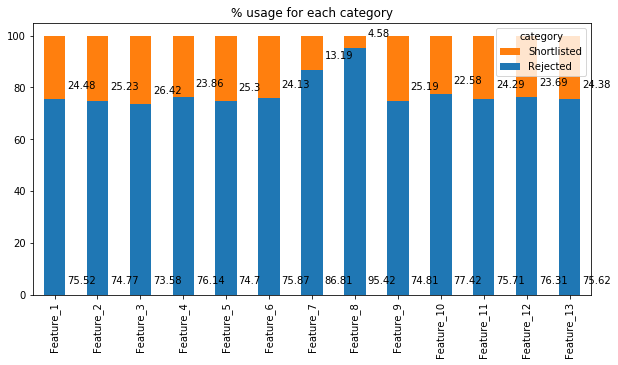

In [9]:
#Let's plot these features on a chart. To view these feature we will write a function:
def plot_bar_chart_from_dataframe(dataframe1,key_column,columns_to_be_plotted):
    import pandas as pd
    test_df1 = dataframe1.groupby(key_column).sum()
    test_df2 = pd.DataFrame()
    for column in columns_to_be_plotted:
        test_df2[column] = round(test_df1[column]/ test_df1[column].sum()*100,2)
    test_df2 = test_df2.T 
    ax = test_df2.plot(kind='bar', stacked=True, figsize =(10,5),legend = 'reverse',title = '% usage for each category')
    for p in ax.patches:
        a = p.get_x()+0.4
        ax.annotate(str(p.get_height()), (a, p.get_y()), xytext=(6, 11), textcoords='offset points')

key_column = 'category'
columns_to_be_plotted = ['Feature_1','Feature_2','Feature_3','Feature_4','Feature_5','Feature_6','Feature_7','Feature_8','Feature_9','Feature_10','Feature_11','Feature_12','Feature_13']
plot_bar_chart_from_dataframe(training_df,key_column,columns_to_be_plotted)

In [11]:
features = training_df[['Feature_1','Feature_2','Feature_3','Feature_4','Feature_5','Feature_6','Feature_7','Feature_8','Feature_9','Feature_10','Feature_11','Feature_12','Feature_13']]
features.head()


,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13
0,877,5055,5.763968,379,73,1,0,0,360,33,359,216,339
1,488,2817,5.772541,219,25,0,0,0,217,4,189,133,194
2,509,2898,5.693517,234,39,0,0,0,200,0,174,103,170
3,313,1912,6.108626,139,20,1,0,0,129,0,113,63,107
4,861,5321,6.180023,266,47,0,0,0,466,15,354,234,329


In [ ]:
from sklearn.preprocessing import LabelEncoder
LE=LabelEncoder()
training_df['category1']=LE.fit_transform(training_df['category'])

In [45]:
#refined
df = training_df[['category1','Feature_1','Feature_2','Feature_3','Feature_4','Feature_5','Feature_9','Feature_10','Feature_11','Feature_12','Feature_13']]
df.head()
df_x = training_df[['Feature_1','Feature_2','Feature_3','Feature_4','Feature_5','Feature_9','Feature_10','Feature_11','Feature_12','Feature_13']]
df.head()


,category1,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13
0,0,877,5055,5.763968,379,73,360,33,359,216,339
1,1,488,2817,5.772541,219,25,217,4,189,133,194
2,0,509,2898,5.693517,234,39,200,0,174,103,170
3,1,313,1912,6.108626,139,20,129,0,113,63,107
4,0,861,5321,6.180023,266,47,466,15,354,234,329


In [46]:
#import for test train split and vect
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


vectoriser = TfidfVectorizer(max_features=None,min_df=1,  # min count for relevant vocabulary
                             strip_accents='unicode',  # replace all accented unicode char 
    # by their corresponding  ASCII char
    analyzer='word',  # features made of words
    token_pattern=r'\w{1,}',  # tokenize only words of 4+ chars
    ngram_range=(1, 1),  # features made of a single tokens
    use_idf=True,  # enable inverse-document-frequency reweighting
    smooth_idf=True,  # prevents zero division for unseen words
    sublinear_tf=False)


x = vectoriser.fit_transform(training_df['News_description'])
y = training_df.category1


#shape of tfidf feature
print(x.shape)

(22477, 126406)
